In [68]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
file_path = "Descriptors.TXT"

df = pd.read_csv(file_path, delimiter='\t')
# Filter rows where 'VEHICLE_CLASS' is 'PASSENGER' i.e remove motorcycles, busses, etc
df = df[df['VEHICLE_CLASS'] == 'PASSENGER']
df = df.drop(columns=['VEHICLE_CLASS','OUT-OF-PROV', 'SOLD', 'SUSPENDED', 'TEMPORARY'])

print(df)

    DESCRIPTOR VALUE  FIT-ACTIVE  FIT-INACTIVE   UNFIT  WRECKED     TOTAL
0    CYLINDERS    00       71086          7117    1183       55     81630
1    CYLINDERS    02        1344          2239     627      506      5469
2    CYLINDERS    03       52111         35711    4119    16719    120649
3    CYLINDERS    04     4737227       4562834  809726  2520714  13729327
4    CYLINDERS    05       48825         60851   10650    27252    168939
..         ...   ...         ...           ...     ...      ...       ...
154       YEAR  1904           3             3       2        1         9
155       YEAR  1903           1            10       4        0        15
156       YEAR  1902           1             4       2        0         8
157       YEAR  1901           0             5       4        0         9
158       YEAR  1900           1            19       0        0        22

[159 rows x 7 columns]


In [23]:
file_path = "MakeAndModel.TXT"

df = pd.read_csv(file_path, delimiter='\t')
# Filter rows where 'VEHICLE_CLASS' is 'PASSENGER' i.e remove motorcycles, busses, etc
df = df[df['VEHICLE_CLASS'] == 'PASSENGER']
df = df[df['MAKE'] != '****']
df = df[df['MODEL-YEAR'] >= 2017]
df = df.drop(columns=['VEHICLE_CLASS','OUT-OF-PROV', 'SOLD', 'SUSPENDED', 'TEMPORARY'])

print(df)

       MAKE MODEL  MODEL-YEAR  FIT-ACTIVE  FIT-INACTIVE  UNFIT  WRECKED  TOTAL
28     ACUR   CDX        2018           0             1      0        0      1
29     ACUR   CDX        2017         999           135     14        2   1243
61     ACUR   IES        2022          91             4      1        0     97
62     ACUR   IES        2021          89             8      0        0     97
63     ACUR   IES        2020         237            39      7        0    288
...     ...   ...         ...         ...           ...    ...      ...    ...
18410  VOLV   ***        2021          12             1      0        0     13
18411  VOLV   ***        2020          14             3      1        0     19
18412  VOLV   ***        2019          55             4      2        0     65
18413  VOLV   ***        2018          31             9      2        0     52
18414  VOLV   ***        2017         266            84     12        0    435

[3350 rows x 8 columns]


In [34]:
# Group by 'MAKE' and sum 'FIT-ACTIVE' and 'TOTAL' values
active_total = df.groupby('MAKE')[['FIT-ACTIVE', 'TOTAL']].sum()

# Sort the DataFrame by the summed 'FIT-ACTIVE' values
active_total['FIT-PERCENTAGE'] = (active_total['FIT-ACTIVE'] / active_total['TOTAL']) * 100
active_total = active_total[active_total['TOTAL'] > 50000]

active_total = active_total.sort_values(by='FIT-PERCENTAGE', ascending=False)
# Display the result
print(active_total)

      FIT-ACTIVE   TOTAL  FIT-PERCENTAGE
MAKE                                    
SUBA      115196  128059       89.955411
TESL       49524   55297       89.560012
HOND      348834  398046       87.636605
MAZD      125542  143788       87.310485
ACUR       50169   58840       85.263426
HYUN      287857  340006       84.662329
TOYT      361345  429605       84.110986
VOLK      131015  156722       83.597070
KIA       140310  168839       83.102838
LEXS       65733   82229       79.938951
NISS      190429  239235       79.599139
AUDI       79663  101747       78.295183
BMW        80425  106050       75.836869
CHEV      142561  190592       74.799047
FORD      214543  291553       73.586278
DODG       87138  119369       72.998852
MERZ       90466  126171       71.701104
GMC        40560   57404       70.657097
JEEP      117518  168563       69.717554


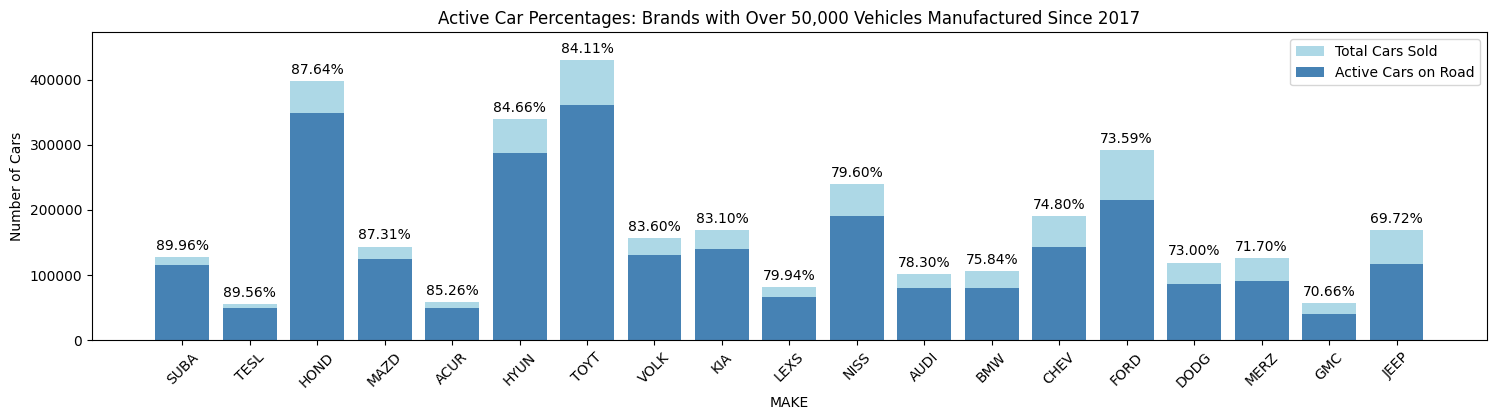

In [72]:
# Sort the DataFrame by the number of active cars
active_total_sorted = active_total.sort_values(by='FIT-PERCENTAGE', ascending=False)

# Plotting the bar chart
fig, ax1 = plt.subplots(figsize=(18, 4))
bars = ax1.bar(active_total_sorted.index, active_total_sorted['TOTAL'], color='lightblue', label='Total Cars Sold')
ax1.bar(active_total_sorted.index, active_total_sorted['FIT-ACTIVE'], color='steelblue', label='Active Cars on Road')
ax1.set_xlabel('MAKE')
ax1.set_ylabel('Number of Cars')
ax1.set_title('Active Car Percentages: Brands with Over 50,000 Vehicles Manufactured Since 2017')
ax1.tick_params(axis='x', rotation=45)

# Annotate each bar with the percentage value
for bar, percentage in zip(bars, active_total_sorted['FIT-PERCENTAGE']):
    height = bar.get_height()
    ax1.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Set y-axis limits with extra space above the largest bar
largest_bar_height = max(active_total_sorted['TOTAL'])
ax1.set_ylim(top=largest_bar_height * 1.1)  # Increase by 10% above the largest bar height

# Move legend to the top right corner
ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

# Display the plot
plt.show()
